# Proyek Klasifikasi Gambar: Animals-10
---


- **Nama:** Muhamad Fajar Faturohman
- **Email:** fajarftr2605@gmail.com
- **ID Dicoding:** mnjarrr

# Outline

- [Import Semua Packages/Library yang Digunakan](#import-semua-packageslibrary-yang-digunakan)
- [Data Preparation](#data-preparation)
  - [Data loading](#data-loading)
  - [Data splitting](#data-splitting)
- [Explanatory Data Analysis)](#explanatory-data-analysis)
- [Data Preprocessing](#data-preprocessing)
- [Modeling](#modeling)
- [Evaluasi dan Visualisasi](#evaluasi-dan-visualisasi)
- [Konversi Model](#konversi-model)
  - [Saved Model](#savedmodel)
  - [TF-Lite](#tf-lite)
  - [TFJS](#tfjs)
- [Inference](#inference)

## Import Semua Packages/Library yang Digunakan

In [1]:
import shutil
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
import requests
import json
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet152V2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Preparation

### Data loading

In [2]:
# Direktori dataset
images_dir = './Animals-10/raw-img/'
train_dir = './Animals-10/train'
val_dir = './Animals-10/val'

In [14]:
def count_total_images(directory):
    total_images = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

    return total_images

images_dir = './Animals-10/raw-img'
total_images = count_total_images(images_dir)
print(total_images)

26179


In [15]:
# Membuat folder train dan val
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Mengumpulkan path gambar dan labelnya
data = []
for class_name in os.listdir(images_dir):
    class_path = os.path.join(images_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            breed_name = class_name
            data.append((img_path, breed_name))

### Data splitting

In [16]:
# Membagi data ke dalam train (80%) dan validation data (test set) (20%)
train_data, val_data = train_test_split(data, test_size=0.2, stratify=[label for _, label in data], random_state=42)

In [17]:
def copy_images(data, target_dir):
    for img_path, breed_name in data:
        breed_dir = os.path.join(target_dir, breed_name)
        os.makedirs(breed_dir, exist_ok=True)
        shutil.copy(img_path, breed_dir)

# Menyalin gambar ke direktori train dan validation
copy_images(train_data, train_dir)
copy_images(val_data, val_dir)

print(f"Total gambar di train set: {len(train_data)}")
print(f"Total gambar di validation set: {len(val_data)}")

Total gambar di train set: 20943
Total gambar di validation set: 5236


## Explanatory Data Analysis

In [40]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

In [51]:
print_images_resolution(train_dir)

gallina: 2478
- (300, 206)
- (245, 300)
- (221, 300)
- (256, 300)
- (300, 215)
- (300, 270)
- (300, 279)
- (232, 300)
- (243, 300)
- (225, 224)
- (300, 197)
- (234, 300)
- (300, 181)
- (300, 300)
- (288, 216)
- (300, 245)
- (300, 190)
- (183, 300)
- (300, 254)
- (300, 199)
- (194, 300)
- (273, 300)
- (300, 263)
- (238, 300)
- (249, 300)
- (300, 272)
- (150, 150)
- (196, 300)
- (286, 300)
- (251, 300)
- (150, 223)
- (300, 165)
- (300, 229)
- (262, 300)
- (300, 174)
- (270, 194)
- (300, 119)
- (300, 238)
- (222, 300)
- (300, 183)
- (200, 300)
- (290, 300)
- (300, 247)
- (300, 128)
- (300, 192)
- (211, 300)
- (235, 300)
- (300, 256)
- (300, 201)
- (240, 180)
- (300, 265)
- (213, 300)
- (224, 300)
- (279, 300)
- (292, 300)
- (283, 178)
- (252, 300)
- (239, 300)
- (300, 167)
- (228, 300)
- (300, 231)
- (262, 192)
- (300, 176)
- (216, 289)
- (300, 295)
- (300, 240)
- (217, 300)
- (300, 185)
- (261, 300)
- (300, 249)
- (300, 194)
- (226, 275)
- (300, 258)
- (300, 203)
- (300, 267)
- (230, 300

In [18]:
# Mengubah label ke bahasa inggris karena sebelumnya label dalam bahasa itali
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
    "dog": "cane", "cavallo": "horse", "elephant": "elefante", "butterfly": "farfalla",
    "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"
}

In [19]:
def rename_directories(base_dir, translate):
    for dir_name in os.listdir(base_dir):
        dir_path = os.path.join(base_dir, dir_name)
        if os.path.isdir(dir_path):
            new_name = translate.get(dir_name, dir_name)
            new_path = os.path.join(base_dir, new_name)
            os.rename(dir_path, new_path)

# Mengganti nama direktori dalam train dan val
rename_directories(train_dir, translate)
rename_directories(val_dir, translate)

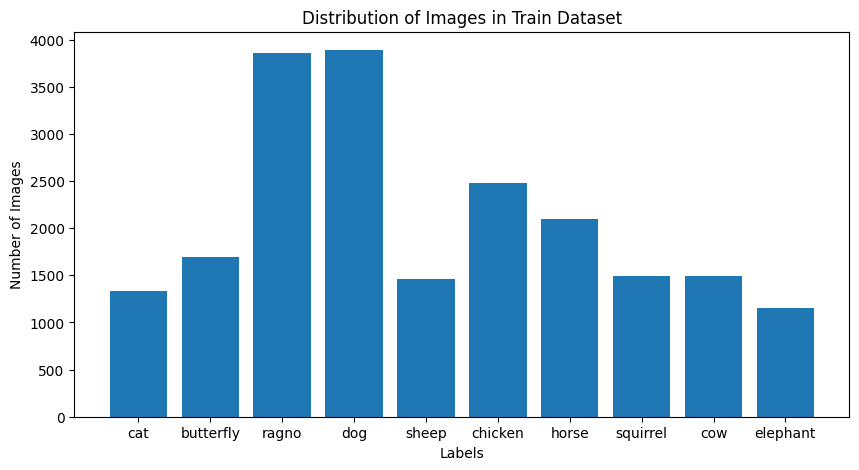

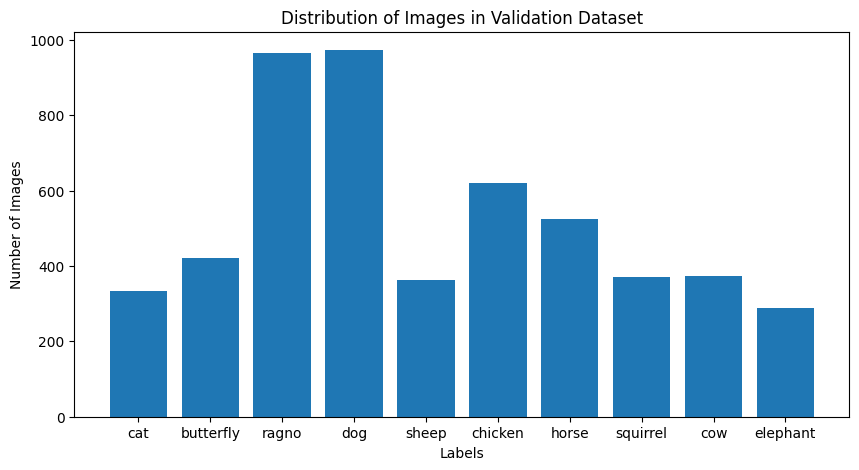

In [20]:
def plot_image_distribution(directory, title):
    labels = []
    counts = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            labels.append(label)
            counts.append(num_images)

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.title(f'Distribution of Images in {title}')
    plt.xlabel('Labels')
    plt.ylabel('Number of Images')
    plt.show()

# Plot distribusi data untuk tiap label dari tran dan val dataset
plot_image_distribution(train_dir, 'Train Dataset')
plot_image_distribution(val_dir, 'Validation Dataset')

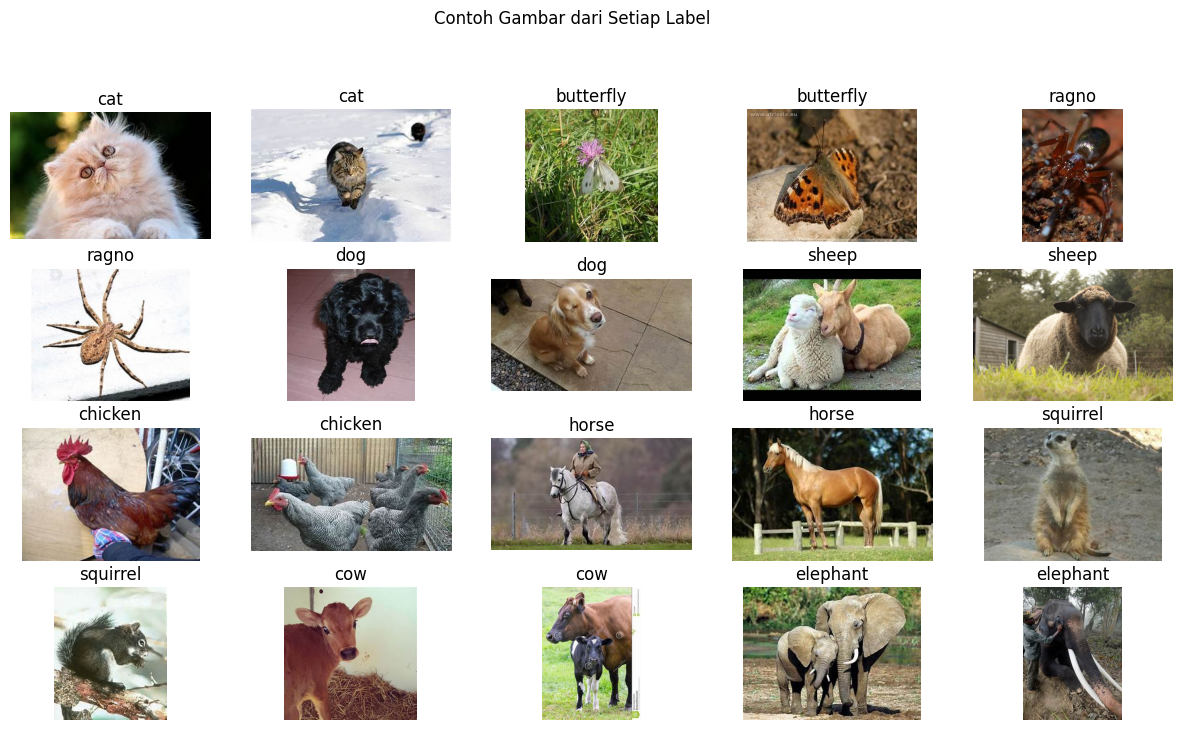

In [21]:
def display_images_from_classes(directory, num_examples=2):
    labels = os.listdir(directory)
    image_paths = []
    titles = []

    for label in labels:
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            images = os.listdir(label_path)[:num_examples]
            for img_name in images:
                img_path = os.path.join(label_path, img_name)
                image_paths.append(img_path)
                titles.append(label)

    # Menampilkan gambar-gambar dari setiap label
    plt.figure(figsize=(15, 10))
    for i, (img_path, title) in enumerate(zip(image_paths, titles)):
        plt.subplot(5, 5, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    
    plt.suptitle('Contoh Gambar dari Setiap Label')
    plt.show()

# Menampilkan contoh gambar dari training set
display_images_from_classes(train_dir, num_examples=2)

## Data Preprocessing

Melakukan pengecekkan apakah terdapat gambar dalam format PNG, karena format tersebut seringkali menimbulkan masalah profil warna sRGB yang salah atau tidak sesuai standar. Walaupun memang tidak selalu menyebabkan masalah yang serius pada training model dan dapat diabaikan, pesan peringatan seperti ini **'iCCP: known incorrect sRGB profile'** dapat muncul berkali-kali pada saat training model dan dapat mengganggu keterbacaan notebook atau kode.

In [22]:
def check_png_files(directory):
    png_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                png_files.append(os.path.join(root, file))
    return png_files

def count_png(directory):
    png_files = check_png_files(directory)
    if png_files:
        print(f'Terdapat {len(png_files)} gambar PNG dalam dataset.')
    else:
        print('Tidak ada gambar PNG dalam dataset.')

count_png(train_dir)
count_png(val_dir)

Terdapat 39 gambar PNG dalam dataset.
Terdapat 12 gambar PNG dalam dataset.


In [23]:
directory = val_dir
def convert_image_to_jpeg(file_path):
    try:
        with Image.open(file_path) as img:
            rgb_img = img.convert("RGB")  # konversi gambar ke format RGB
            jpeg_file_path = file_path.rsplit('.', 1)[0] + '.jpg'  # ubah ekstensi ke .jpg
            rgb_img.save(jpeg_file_path, "JPEG")
            print(f"Converted {file_path} to {jpeg_file_path}")
            return jpeg_file_path
    except Exception as e:
        print(f"Could not convert image {file_path}: {e}")
        return None
def convert(directory):
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.png'):
                file_path = os.path.join(root, filename)
                convert_image_to_jpeg(file_path)
                os.remove(file_path)

In [24]:
convert(train_dir)

Converted ./Animals-10/train/cat/e837b90a2ef7053ed1584d05fb1d4e9fe777ead218ac104497f5c979aee4b1bf_640.png to ./Animals-10/train/cat/e837b90a2ef7053ed1584d05fb1d4e9fe777ead218ac104497f5c979aee4b1bf_640.jpg
Converted ./Animals-10/train/butterfly/eb32b8072bfd033ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png to ./Animals-10/train/butterfly/eb32b8072bfd033ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
Converted ./Animals-10/train/butterfly/eb32b40820fd063ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png to ./Animals-10/train/butterfly/eb32b40820fd063ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
Converted ./Animals-10/train/butterfly/eb35b3072dfd033ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png to ./Animals-10/train/butterfly/eb35b3072dfd033ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
Converted ./Animals-10/train/butterfly/eb3db20b28f3093ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.png to ./Animals-10/train/butterfly/

In [25]:
convert(val_dir)

Converted ./Animals-10/val/butterfly/eb32b6092afd043ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png to ./Animals-10/val/butterfly/eb32b6092afd043ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
Converted ./Animals-10/val/butterfly/ea37b4072af2093ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.png to ./Animals-10/val/butterfly/ea37b4072af2093ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
Converted ./Animals-10/val/butterfly/e832b7062ff6093ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png to ./Animals-10/val/butterfly/e832b7062ff6093ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
Converted ./Animals-10/val/butterfly/ea37b30620f6073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.png to ./Animals-10/val/butterfly/ea37b30620f6073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
Converted ./Animals-10/val/butterfly/ea36b50f2cfc063ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.png to ./Animals-10/val/butterfly/ea36b50f

In [26]:
count_png(train_dir)
count_png(val_dir)

Tidak ada gambar PNG dalam dataset.
Tidak ada gambar PNG dalam dataset.


In [ ]:
# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    seed=42
)

val_ds = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    seed=42
)

In [28]:
# Dapatkan nama kelas dari train_ds sebelum pemrosesan
class_names = train_ds.class_names

# Definisikan RandomRotation diluar fungsi
rotation_layer = tf.keras.layers.RandomRotation(factor=0.15) # 
def train_preprocess_and_augment(image, label):
    image = image / 255.0  # Scale images to [0, 1]
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.flip_left_right(image)  # Flip image horizontally
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.central_crop(image, central_fraction=0.9) 
    
    image = rotation_layer(image)
    image = tf.image.resize(image, [224, 224])

    image = tf.clip_by_value(image, 0.0, 1.0)  # Pastikan nilai gambar berada dalam kisaran [0, 1] setelah augmentasi
    
    return image, label

def val_preprocess(image, label):
    image = image / 255.0  # Scale images to [0, 1]
    
    return image, label

# Apply preprocess dan augmentasi
train_ds = train_ds.map(train_preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(val_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Apply prefetch untuk meningkatkan performa
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

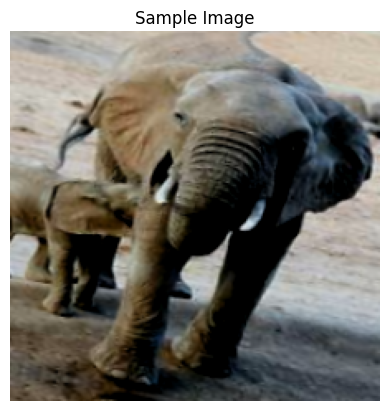

Train dataset size: 655 batches
Validation dataset size: 164 batches
Train batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 10)


In [29]:
# visualisasikan sebuah batch
data_iterator = train_ds.as_numpy_iterator()
data_batch = data_iterator.next()
img = data_batch[0][0]
plt.imshow(img)
plt.title('Sample Image')
plt.axis('off')
plt.show()

# Cek dataset shapes
print(f"Train dataset size: {len(train_ds)} batches")
print(f"Validation dataset size: {len(val_ds)} batches")

# Cek batch shape
print(f"Train batch shape: {data_batch[0].shape}")
print(f"Labels batch shape: {data_batch[1].shape}")

## Modeling

Class `SelfAttention` adalah implementasi lapisan (layer) Self-Attention sederhana dalam jaringan saraf konvolusi (CNN) yang bertujuan untuk meningkatkan representasi fitur dengan memungkinkan model untuk fokus pada bagian penting dari input. Penjelasan lengkap mengenai integrasi Self-Attention dengan CNN dapat dibaca pada paper yang berjudul: [On the Integration of Self-Attention and Convolution](https://arxiv.org/pdf/2111.14556)

In [30]:
class SelfAttention(layers.Layer):
    def __init__(self, num_channels):
        super(SelfAttention, self).__init__()
        self.num_channels = num_channels
        self.query_conv = layers.Conv2D(filters=num_channels // 8, kernel_size=1, padding='same')
        self.key_conv = layers.Conv2D(filters=num_channels // 8, kernel_size=1, padding='same')
        self.value_conv = layers.Conv2D(filters=num_channels, kernel_size=1, padding='same')
        self.gamma = tf.Variable(0.0, trainable=True)

    def call(self, inputs):
        # Hitung queries, keys, dan values
        queries = self.query_conv(inputs)
        keys = self.key_conv(inputs)
        values = self.value_conv(inputs)

        # Flatten dimensi spasial untuk melakukan perkalian matriks
        queries = tf.reshape(queries, [tf.shape(inputs)[0], -1, self.num_channels // 8])
        keys = tf.reshape(keys, [tf.shape(inputs)[0], -1, self.num_channels // 8])
        values = tf.reshape(values, [tf.shape(inputs)[0], -1, self.num_channels])

        # Hitung attention map
        attention = tf.matmul(queries, keys, transpose_b=True)
        attention = tf.nn.softmax(attention, axis=-1)

        # Hitung attended features
        attended_features = tf.matmul(attention, values)
        attended_features = tf.reshape(attended_features, tf.shape(inputs))

        return self.gamma * attended_features + inputs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
class ComplexSelfAttention(layers.Layer):
    def __init__(self, num_channels, num_heads=8):
        super(ComplexSelfAttention, self).__init__()
        self.num_channels = num_channels
        self.num_heads = num_heads
        self.query_conv = layers.Conv2D(filters=num_channels // num_heads, kernel_size=1, padding='same')
        self.key_conv = layers.Conv2D(filters=num_channels // num_heads, kernel_size=1, padding='same')
        self.value_conv = layers.Conv2D(filters=num_channels, kernel_size=1, padding='same')
        self.shift_conv = layers.Conv2D(filters=num_channels // num_heads, kernel_size=1, padding='same')
        
        # Fully connected layer for stage I
        self.fc_stage1 = layers.Dense(units=num_channels, activation='relu')
        
        # Shift & Summation stage weights
        self.alpha = tf.Variable(0.5, trainable=True)
        
        # Self-attention stage weight
        self.beta = tf.Variable(0.5, trainable=True)

        # Gamma scaling factor for the attention mechanism
        self.gamma = tf.Variable(0.0, trainable=True)

    def call(self, inputs):
        # Stage I: Shift & Summation
        
        # Apply convolutions for query, key, value, and shifted features
        queries = self.query_conv(inputs)
        keys = self.key_conv(inputs)
        values = self.value_conv(inputs)
        shifted_features = self.shift_conv(inputs)
        
        # Flatten spatial dimensions
        queries = tf.reshape(queries, [tf.shape(inputs)[0], -1, self.num_channels // self.num_heads])
        keys = tf.reshape(keys, [tf.shape(inputs)[0], -1, self.num_channels // self.num_heads])
        values = tf.reshape(values, [tf.shape(inputs)[0], -1, self.num_channels])
        shifted_features = tf.reshape(shifted_features, [tf.shape(inputs)[0], -1, self.num_channels // self.num_heads])
        
        # Shift operation: applying fully connected layer to the shifted features
        shifted_output = self.fc_stage1(shifted_features)
        
        # Stage II: Self-Attention
        
        # Attention map computation
        attention = tf.matmul(queries, keys, transpose_b=True)
        attention = tf.nn.softmax(attention, axis=-1)
        
        # Apply attention to values
        attended_features = tf.matmul(attention, values)
        attended_features = tf.reshape(attended_features, tf.shape(inputs))
        
        # Final output combination: using alpha and beta scaling factors
        output = self.alpha * shifted_output + self.beta * attended_features
        
        # Combine attended features with the original input, scaled by gamma
        final_output = self.gamma * output + inputs

        return final_output


`ResNet152V2` adalah arsitektur jaringan saraf konvolusi (CNN) yang merupakan bagian dari keluarga ResNet (Residual Networks). Keunggulan utama dari pre-trained model ini adalah penggunaan residual connections, yang membantu mencegah masalah vanishing gradient pada jaringan yang sangat dalam, memastikan bahwa informasi penting dapat diteruskan melalui seluruh lapisan model tanpa kehilangan relevansi.

In [31]:
# Load ResNet152V2
base_model = ResNet152V2(include_top=False, input_shape=(224, 224, 3))

# Freeze the layer
base_model.trainable = False

model = Sequential([
    base_model,

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    SelfAttention(num_channels=128),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         2359424   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 3, 3, 128)         0         
                                                                 
 self_attention (SelfAttent  (None, 3, 3, 128)         2

In [32]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2,
    patience=1, min_lr=1e-6
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights = True)

checkpoint_path = './best_model.h5'

checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True
)

In [34]:
batch = 32
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch,
    epochs=epochs,
    callbacks=[reduce_lr, checkpoint_callback],
)

Epoch 1/10
655/655 [==============================] - ETA: 0s - loss: 1.2152 - accuracy: 0.6259

/Users/fajar/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


655/655 [==============================] - 880s 1s/step - loss: 1.2152 - accuracy: 0.6259 - val_loss: 0.2122 - val_accuracy: 0.9471 - lr: 1.0000e-05
Epoch 2/10
655/655 [==============================] - 786s 1s/step - loss: 0.5101 - accuracy: 0.8490 - val_loss: 0.1560 - val_accuracy: 0.9593 - lr: 1.0000e-05
Epoch 3/10
655/655 [==============================] - 786s 1s/step - loss: 0.3662 - accuracy: 0.8911 - val_loss: 0.1378 - val_accuracy: 0.9610 - lr: 1.0000e-05
Epoch 4/10
655/655 [==============================] - 632s 965ms/step - loss: 0.2819 - accuracy: 0.9177 - val_loss: 0.1297 - val_accuracy: 0.9628 - lr: 1.0000e-05
Epoch 5/10
655/655 [==============================] - 618s 944ms/step - loss: 0.2192 - accuracy: 0.9397 - val_loss: 0.1243 - val_accuracy: 0.9641 - lr: 1.0000e-05
Epoch 6/10
655/655 [==============================] - 615s 939ms/step - loss: 0.1685 - accuracy: 0.9593 - val_loss: 0.1211 - val_accuracy: 0.9645 - lr: 1.0000e-05
Epoch 7/10
655/655 [======================

## Evaluasi Dan Visualisasi

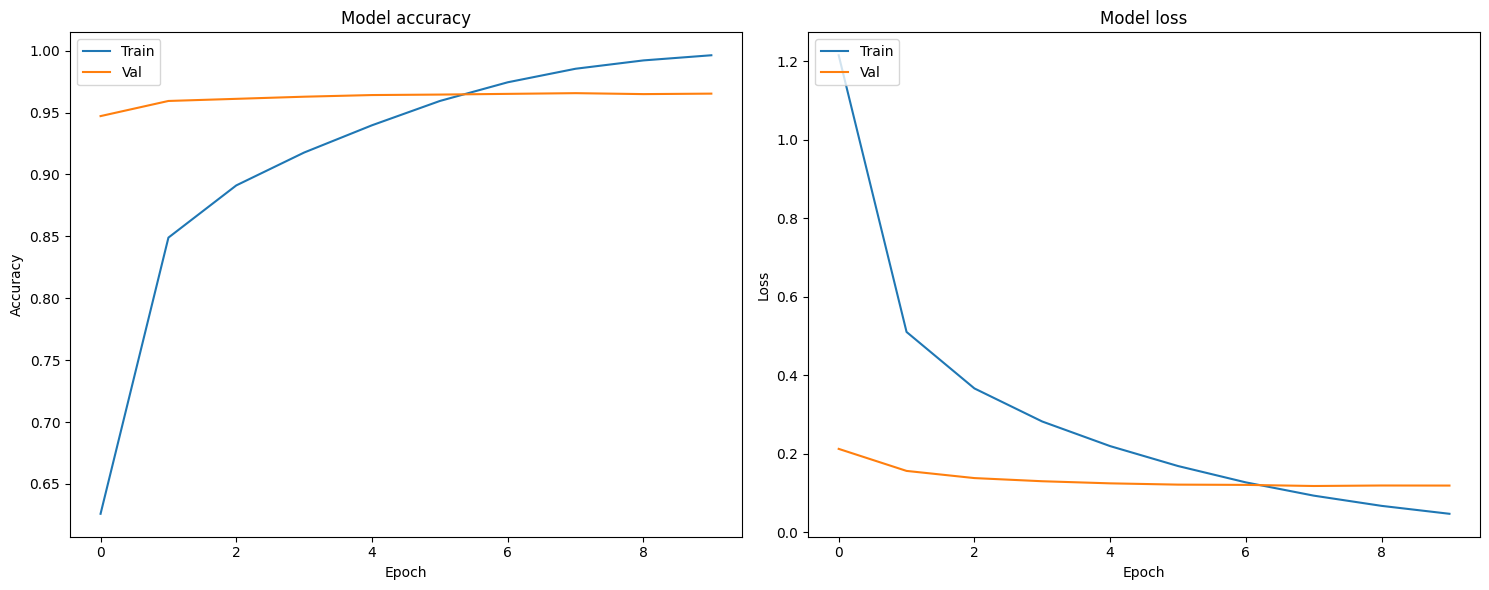

In [35]:
# Plot training & validation accuracy
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [36]:
# Fungsi untuk mengumpulkan prediksi dan label dari dataset
def collect_predictions_and_labels(dataset):
    all_labels = []
    all_preds = []
    
    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(labels, axis=1)
        
        all_labels.extend(true_labels)
        all_preds.extend(predicted_labels)
    
    return np.array(all_labels), np.array(all_preds)

# Mengumpulkan prediksi dan label dari dataset validasi
y_true, y_pred = collect_predictions_and_labels(val_ds)

1/1 [==============================] - 5s 5s/step


In [37]:
# Menghitung accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

Accuracy Score: 0.9652


In [38]:
# Menghitung classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.97      0.97      0.97       422
         cat       0.98      0.96      0.97       334
     chicken       0.99      0.98      0.98       620
         cow       0.94      0.90      0.92       373
         dog       0.96      0.97      0.97       973
    elephant       0.98      0.96      0.97       289
       horse       0.94      0.96      0.95       525
       ragno       0.99      0.99      0.99       964
       sheep       0.89      0.94      0.91       364
    squirrel       0.98      0.97      0.98       372

    accuracy                           0.97      5236
   macro avg       0.96      0.96      0.96      5236
weighted avg       0.97      0.97      0.97      5236



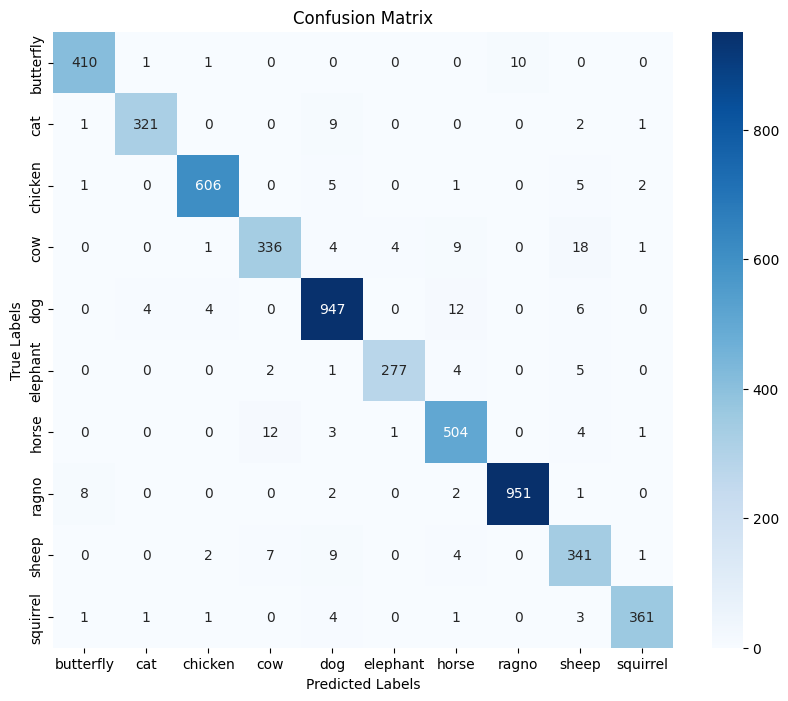

In [39]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

### SavedModel

In [40]:
saved_model_dir = 'saved_model/'
tf.saved_model.save(model, saved_model_dir)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


### TF-Lite

In [43]:
# Membuat folder 'tflite' jika belum ada
os.makedirs('tflite', exist_ok=True)

# Simpan nama kelas ke dalam file labels.txt
with open('tflite/labels.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

In [42]:
# Mengonversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TF-Lite ke file
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/fz/p1481t9n2jj2kgrtykj1h8_80000gn/T/tmpagv7a_om/assets


INFO:tensorflow:Assets written to: /var/folders/fz/p1481t9n2jj2kgrtykj1h8_80000gn/T/tmpagv7a_om/assets
2024-08-12 08:14:50.198847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-08-12 08:14:50.198872: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 435, Total Ops 825, % non-converted = 52.73 %
 * 435 ARITH ops

- arith.constant:  435 occurrences  (f32: 427, i32: 8)



  (f32: 103)
  (f32: 2)
  (f32: 159)
  (f32: 2)
  (f32: 5)
  (f32: 1)
  (f32: 53)
  (i32: 2)
  (f32: 52)
  (f32: 4)
  (i32: 1)
  (f32: 2)
  (i32: 1)


### TFJS

In [59]:
model.save('model.h5')

In [55]:
# konversi model.h5
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

## Inference

Inference dilakukan menggunakan savedmodel dengan tf serving menggunakan docker image.

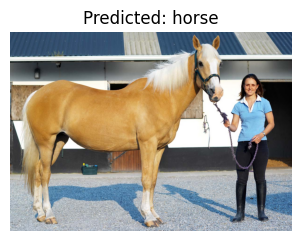

Predicted label: horse


In [78]:
labels = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'spider', 'sheep', 'squirrel']

image_path = './test/1-GettyImages-stk208112rke.jpg'

# Load image dan preprocess
image = Image.open(image_path)
image_resized = image.resize((224, 224))  # Sesuaikan ukuran dengan input model
image_array = np.array(image_resized) / 255.0  # Normalisasi
image_array = np.expand_dims(image_array, axis=0)  # Tambahkan dimensi batch

# Siapkan request data
data = json.dumps({"signature_name": "serving_default", "instances": image_array.tolist()})
headers = {"Content-Type": "application/json"}

# Mengirim request ke TensorFlow Serving
response = requests.post('http://localhost:8501/v1/models/my_model:predict', data=data, headers=headers)
predictions = response.json()

# Mengambil probabilitas dari prediksi
probabilities = predictions['predictions'][0]

# Menentukan indeks kelas dengan probabilitas tertinggi
predicted_index = np.argmax(probabilities)

# Mengambil label kelas yang sesuai dari daftar label
predicted_label = labels[predicted_index]

# Menampilkan gambar dan hasil prediksi
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

print(f"Predicted label: {predicted_label}")